# Model Training

## Table of Contents
- Data Preparation
- Modelling
    - ARIMA
    - Random Forest
    - XGBoost
- Comparison of Models
- Results

<br>

---

### Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/cleaned_df_v2.csv", index_col=False)
df = df.iloc[: , 1:]

# convert date
df['year_month'] = pd.to_datetime(df['year_month'])
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

In [2]:
from sklearn.model_selection import train_test_split

features = ['year', 'month', 'us_state', 'make', 'phone_series',  'model_family','model_age_months', 
            'predecessor', 'successor', 'model', 'sku', 'sku_no_colour', 'colour', 'size', 'claims', 
            'ir_rate_swap', 'ir_rate_replacement', 'ir_rate_monthly', 'churn_rate'] # 19 features
target = 'closing_subs_monthly'
categorical_cols = ["us_state", "make", "phone_series", "model_family", "colour", "size"]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

X_train.head()

,year,month,us_state,make,phone_series,model_family,model_age_months,predecessor,successor,model,sku,sku_no_colour,colour,size,claims,ir_rate_swap,ir_rate_replacement,ir_rate_monthly,churn_rate
6615,2023,6,Nevada,Apple,IPHONE 12,APPLE IPHONE 12 PRO MAX,31,APPLE IPHONE 11 PRO MAX,APPLE IPHONE 13 PRO MAX,IPHONE 12 PRO MAX 5G 256GB GRAPHITE,IPH12PRM5G256GRY,IPH12PRM5G256,Gray,256,3.0,0.0,0.0,0.001585,0.049128
9440,2023,5,Nevada,Apple,IPHONE XR,APPLE IPHONE XR,55,APPLE IPHONE X,APPLE IPHONE 11,IPHONE XR 64GB BLACK,IPHXR64BLK,IPHXR64,Black,64,0.0,0.0,0.0,0.000000,0.055838
1549,2022,12,Texas,Oppo,OPPO A90,OPPO A94,21,First Model,Last Model,A94 128GB SILVER,A94128SIL,A94128,Silver,128,0.0,0.0,0.0,0.000000,0.073171
10717,2019,9,Nevada,Samsung,SAMSUNG GALAXY NOTE 9,SAMSUNG GALAXY NOTE 9,13,First Model,Last Model,GALAXY NOTE 9 128GB BLACK,NOTE9128BLK,NOTE9128,Black,128,16.0,0.0,0.0,0.002614,0.035778
3034,2021,4,California,Samsung,GALAXY S21,SAMSUNG GALAXY S21 PLUS,14,SAMSUNG GALAXY S20 PLUS,SAMSUNG GALAXY S22 PLUS,GALAXY S21 PLUS 5G 256GB BLACK,GXYS21P5G256BLK,GXYS21P5G256,Black,256,0.0,0.0,0.0,0.000000,0.027237


<br>

---

## Time series model: ARIMA (AutoRegressive Integrated Moving Average) model

Data preparation

In [3]:
# Split the data into training and test sets
train_data = df[df['year_month'] < '2023-01-01']  # Data up to January 2023
test_data = df[df['year_month'] >= '2023-01-01']  # Data from January 2023 onwards

In [4]:
# Sort by 'year' and 'month'
train_data['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group data by month (sum or average closing_subs_monthly)
monthly_data = train_data.groupby('year_month')['closing_subs_monthly'].sum()
monthly_data.head()

/var/folders/pg/k1hh45tx53v5c4hp65ntyjtc0000gn/T/ipykernel_99132/577725344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))


year_month
2019-01-01    189795
2019-02-01    201621
2019-03-01    266721
2019-04-01    273176
2019-05-01    280606
Name: closing_subs_monthly, dtype: int64

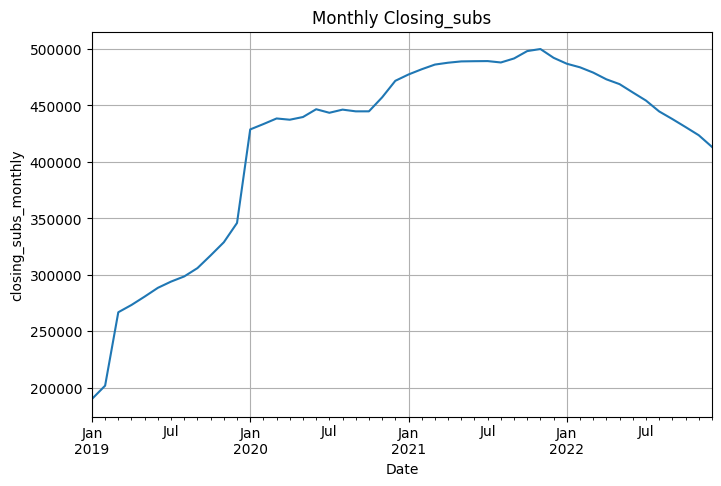

In [5]:
# Plot closing_subs_monthly VS Date
plt.figure(figsize=(8, 5))
monthly_data.plot()
plt.title('Monthly Closing_subs')
plt.xlabel('Date')
plt.ylabel('closing_subs_monthly')
plt.grid(True)
plt.show()

Overall, we see that the number of closing subs increases to a peak around the 3 quearter of 2021, then decreases.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary

ADF Statistic: -2.317070025499938
p-value: 0.16652163628497846


In [7]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
result_diff = adfuller(monthly_data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -0.16590671414231548
p-value (Differenced): 0.9424653057150388


Now that the data is stationary (or made stationary), we can fit an ARIMA model.

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(monthly_data, order=(5, 1, 0))  # p=5, d=1, q=0 (can fine tune)
model_fit = model.fit()

# Summarize the model
# model_fit.summary()

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


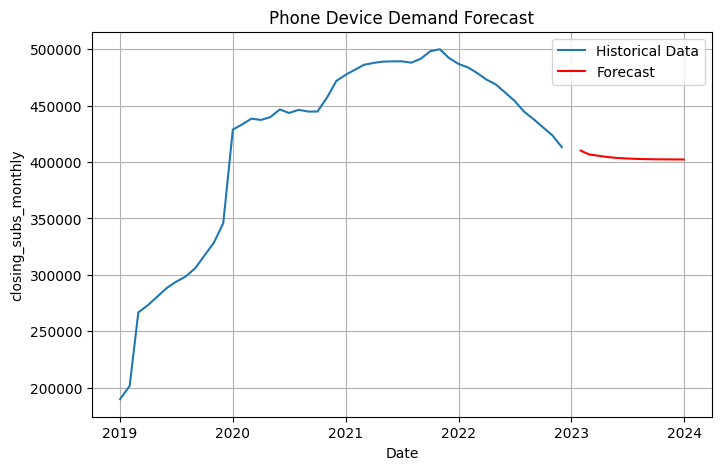

In [9]:
# Forecast for the next 2 months
forecast = model_fit.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(8, 5))
plt.plot(monthly_data.index, monthly_data, label='Historical Data')
plt.plot(pd.date_range(monthly_data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('Phone Device Demand Forecast')
plt.xlabel('Date')
plt.ylabel('closing_subs_monthly')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

forecast = model_fit.forecast(steps=11)
test_data_output = test_data.groupby('year_month')['closing_subs_monthly'].sum()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data_output, forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_output, forecast))

# Print the results
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 54720.358560457935
RMSE: 64191.68934777516


Phone demand forcast for the next 2 months (January and February 2025)

In [11]:
# Sort by 'year' and 'month'
train_data = df.copy()
train_data['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group data by month (sum or average closing_subs_monthly)
monthly_data = train_data.groupby('year_month')['closing_subs_monthly'].sum()
monthly_data.head()

year_month
2019-01-01    189795
2019-02-01    201621
2019-03-01    266721
2019-04-01    273176
2019-05-01    280606
Name: closing_subs_monthly, dtype: int64

In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary

ADF Statistic: -1.4271882144171455
p-value: 0.5691745925645393


In [13]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
result_diff = adfuller(monthly_data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -4.737434971528249
p-value (Differenced): 7.153232399295313e-05


In [ ]:
# Fit ARIMA model
model = ARIMA(monthly_data, order=(5, 1, 0))  # p=5, d=1, q=0 (can fine tune)
model_fit = model.fit()

future_forecast = model_fit.forecast(steps=2) 
print(f"Future forecasted demand for Dec 2023 and Jan 2025: \n{future_forecast}")

Future forecasted demand for Jan 2023 and Feb 2025: 
2023-12-01    281760.594818
2024-01-01    276819.091405
Freq: MS, Name: predicted_mean, dtype: float64


/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Interpretation:
- Mean Absolute Error (MAE):
    - The MAE of 5.0 indicates that, on average, the forecasted values are off by 5 units from the actual values. This is a straightforward measure of the error, showing how far off the predictions are in terms of absolute values, without considering the direction of the error.
    - In practical terms, this means that for each forecasted value, the difference between the actual and predicted value is, on average, 5 units.

- Root Mean Squared Error (RMSE):
    - The RMSE of 5.0 suggests that the forecast error, on average, has a magnitude of 5.0, taking into account the squared differences. Since the MAE and RMSE are identical here, it indicates that the errors are consistent across all data points and are relatively small in magnitude.

<br>

---

## RandomForestRegressor to predict closing_subs_monthly

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42)) 
])

# Model training
model_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1870.7079620144557


Phone demand forcast for the next 2 months (January and February 2025)

In [16]:
# Create a DataFrame for the next 2 months
future_months_data = pd.DataFrame({
    'year': [2023, 2024],  # Next 2 months (2025)
    'month': [12, 1],       # January and February
    'us_state': ['California', 'California'],  # 2 values, one for each month
    'make': ['Apple', 'Apple'],
    'phone_series': ['IPHONE 12', 'IPHONE 12'],
    'model_family': ['APPLE IPHONE 12 PRO MAX', 'APPLE IPHONE 12 PRO MAX'],
    'colour': ['Gray', 'Gray'],
    'size': [256, 256],
    'model_age_months': [31, 31],
    'predecessor': ['APPLE IPHONE 11 PRO MAX', 'APPLE IPHONE 11 PRO MAX'],
    'successor': ['APPLE IPHONE 13 PRO MAX', 'APPLE IPHONE 13 PRO MAX'],
    'model': ['IPHONE 12 PRO MAX 5G 256GB GRAPHITE', 'IPHONE 12 PRO MAX 5G 256GB GRAPHITE'],
    'sku': ['IPH12PRM5G256GRY', 'IPH12PRM5G256GRY'],
    'sku_no_colour': ['IPH12PRM5G256', 'IPH12PRM5G256'],
    'claims': [3.0, 3.0],
    'ir_rate_swap': [0.0, 0.0],
    'ir_rate_replacement': [0.0, 0.0],
    'ir_rate_monthly': [0.001585, 0.001585],
    'churn_rate': [0.049128, 0.049128]
})

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Predict the closing_subs_monthly for the next 2 months
future_predictions = model_pipeline.predict(future_months_data)

# Display the predicted closing_subs_monthly for the next 2 months
print(f'Predicted closing_subs_monthly for Dec 2023 and Jan 2024: {future_predictions}')


Root Mean Squared Error (RMSE): 1870.7079620144557
Predicted closing_subs_monthly for Dec 2023 and Jan 2024: [1199.25661648 1199.25661648]


<br>

---

## XGBoost

XGBoost is an ensemble learning method that combines the predictions of multiple weak models (decision trees) to create a strong predictive model.

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X_train)

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Using GridSearch CV to find the best hyperparameters

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the column transformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Create the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=3244)

# Fit the model to the training data
model.fit(X_train_processed, y_train)

# Evaluate the model on the test data (transforming the test data using the already fitted preprocessor)
X_test_processed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_processed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_processed, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test_processed)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 3497814.339077712
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Mean Squared Error: 3502797.2223229036


Phone demand forcast for the next 2 months (January and February 2025)

In [19]:
# Ensure all categorical columns are included and consistent with the training data
future_months_data_processed = preprocessor.transform(future_months_data)

# Make predictions using the best model
future_predictions = best_model.predict(future_months_data_processed)

# Display the predicted closing_subs_monthly for the next 2 months
print(f'Predicted closing_subs_monthly for Dec 2023 and Jan 2024: {future_predictions}')

Predicted closing_subs_monthly for Dec 2023 and Jan 2024: [1202.2214 1202.2214]


---

<br>


# Model Comparison

**_Predicted closing_subs_monthly for Dec 2023 and Jan 2024 for the 3 models are:_**      
- ARIMA: [281760.594818, 276819.091405]
- RandomForest: [1199.25661648 1199.25661648]
- XGBoost: [1202.2214 1202.2214]

**_Observations_**  



Model Evaluation